## HINMINE

HINMINE [[1]](#fn1) (Heterogeneous Information Network Mining with Information Retrieval Heuristics) is a methodology for *decomposition* of heterogeneous information networks, e.g. networks consisting of multiple node and edge types. This notebooks serves as a demonstration of HINMINE's basic capabilities. The following packages are required to run this notebook:

- py3plex==0.83
- pandas==1.1.4
- seaborn==0.11.0
- tqdm==4.51.0
- scikit-learn==0.23.2

## Theoretical preliminaries

HINMINE operates on heterogeneous information networks (HINs). Formally, HINs can be defined as typed graphs as follows:

$\textrm{HIN} = (N, E, N_t, E_t),$

where $N$ is the set of nodes, $E$ the set of edges, $N_t$ the set of node types (each element of $N$ gets assigned a type from $N_t$) and edge types $E_t$ (each edge is assigned a type from $E_t$). The key idea of HINMINE can be summarised in the following two steps:
1. Network decomposition
2. Propositionalization

The first point (1.) attempts to simplify the initial $\textrm{HIN}$ into a graph $G = (N, E, w)$, where $w$ is a set of real-valued weights assigned to each edge from $E$ (one weight per edge). HINMINE achieves such decomposition by first selecting types of *meta paths* that shall be used for decomposition. Such paths are counted with respect to the number of times they link a given pair of nodes of interest, and aggregated.
More formally, given a heuristic function $f$, a weight of an edge between the two nodes $u$ and $v$ is computed as
\begin{align}
  \label{eq:weight}
 w(u,v) = \sum_{ \substack {m \in M \\ (u, m)\in E\\ (m, v)\in E}} f(m);
\end{align}

---
<span id="fn1"> [1] Kralj, J., Robnik-Šikonja, M. & Lavrač, N. HINMINE: heterogeneous information network mining with information retrieval heuristics. J Intell Inf Syst 50, 29–61 (2018). </span>

---

## Usecase

In the following usecase, we will demonstrate how HINMINE can be adopted for the task of movie genre classification from a heterogeneous information network of movie actors, directors and movies. Let's explore possible decomposition cycles (meta-paths used during counting). First, store the [IMDB dataset](https://github.com/SkBlaz/py3plex/blob/master/datasets/imdb.gpickle) into a local folder `data`. Next, load the data and begin the exploration.

In [10]:
from urllib.request import urlopen
from py3plex.core import multinet
import warnings
warnings.filterwarnings('ignore')

data = urlopen('https://github.com/SkBlaz/py3plex/raw/master/datasets/imdb.gpickle')
with open('data/imdb.gpickle', 'wb') as fp:
    fp.write(data.read())

dataset = "data/imdb.gpickle"

# Construct a heterogeneous information network object
multilayer_network = multinet.multi_layer_network().load_network(
    input_file=dataset, directed=True, input_type=dataset.split(".")[-1])

# Show some basic statistics
multilayer_network.basic_stats()

Parsing gpickle..
-------------------- 
 Computing core stats of the network 
 --------------------
Name: 
Type: MultiDiGraph
Number of nodes: 6384
Number of edges: 14592
Average in degree:   2.2857
Average out degree:   2.2857
Number of unique node IDs: 6342


Let's explore how edges look like in such a network. Each edge is composed of three main parts: node 1, node 2 and edge data. Note that nodes are in fact tuples (id, type). In edge data, you can see that e.g., 'acts_in' and 'features' are two possible edge types.

In [11]:
first_edges = list(multilayer_network.get_edges(data=True))[0:10]
for edge in first_edges:
    print(edge)

(('ruthay', 'person'), ('movie_81', 'movie'), {'type': 'acts_in'})
(('movie_81', 'movie'), ('buddy_guy', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('william_denis', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('marshall_bell', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('chuck_bacino', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('jacob_berenger', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('fairuza_balk', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('michael_nicolosi', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('seymour_cassel', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('phil_boardman', 'person'), {'type': 'features'})


Let's try to visualize this network next! We have two main types of nodes: humans (green) and movies (red). We are interested in obtaining only the network consisting of red nodes by accounting for the green ones.

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning parsing..
Using custom init positions!


100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


BarnesHut Approximation  took  0.55  seconds
Repulsion forces  took  9.19  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


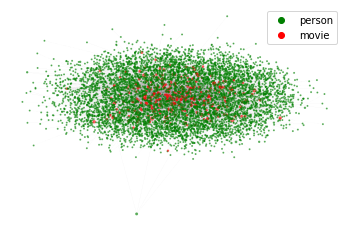

In [12]:
from py3plex.visualization.multilayer import hairball_plot

hairball_plot(multilayer_network.core_network,
              layout_parameters = {"iterations": 5},
              scale_by_size = True,
              legend = True,
              layout_algorithm = "force")

Let's identify possible decomposition cycles. These are just paths connecting the target node pairs, which are in this case the "movie" types. HINMINE finds four relevant decomposition paths.

In [13]:
triplet_set = list(set(multilayer_network.get_decomposition_cycles()))
print("\n".join(triplet_set))

Target type: {'movie'}
movie_____features_____person_____acts_in_____movie
movie_____directed_by_____person_____directed_____movie
movie_____features_____person_____directed_____movie
movie_____directed_by_____person_____acts_in_____movie


We use decomposition paths to obtain a frequency-weighted network of movies.

In [14]:
## Get the decomposition. For other heuristics, see the HINMINE paper.
decomposition = list(multilayer_network.get_decomposition(heuristic=["tf"], cycle = triplet_set))[0]

## The obtained structure is a sparse matrix.
print(decomposition)

Successfully decomposed: tf
(<297x297 sparse matrix of type '<class 'numpy.float64'>'
	with 3281 stored elements in Compressed Sparse Row format>, array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'tf')


The obtained decomposition is a *homogeneous network*. This means that all existing machinery, suitable for working with this type of networks is now possible to use. Kralj et al. [[1]](#fn1) exploited the Personalized PageRank algorithm for learning node representations. Here, a personalized PageRank vector is computed for each node, and *concatenated* to obtain the final representation. Note that this representation serves the same purpose as e.g., node2vec vectors.

In [6]:
# We first import some additional functionality from the py3plex library (and sklearn, which was installed as part of py3plex!)
from py3plex.algorithms.network_classification import PPR

# The decomposed matrix is the 0-th element
decomposed_network = decomposition[0]

# The labels are the first element (multilabel classification -> one movie multiple possible genres)
labels = decomposition[1]

# compute personalized PageRank vectors for each movie.
vectors = PPR.construct_PPR_matrix(decomposed_network)

# This must be a dense matrix!
print(vectors)

[[0.         0.05099809 0.00278758 ... 0.0029905  0.0150286  0.0014722 ]
 [0.02219235 0.         0.00419921 ... 0.00165601 0.02839547 0.00205116]
 [0.00815168 0.02821877 0.         ... 0.00067962 0.0092428  0.00107619]
 ...
 [0.01296204 0.01649483 0.00100736 ... 0.         0.00603935 0.00050871]
 [0.01349753 0.0586053  0.00283872 ... 0.00125138 0.         0.00334351]
 [0.00675068 0.02161365 0.00168752 ... 0.00053815 0.01707043 0.        ]]


The obtained dense matrix can be used for down-stream learning. Let's classify the first genre with the SVM.

In [7]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import cross_val_score

## target space
Y = labels[:,0]
clf = SVC() # Let's use default SVM learner.
cross_val_scores = cross_val_score(clf, vectors, Y, cv=10, scoring = "accuracy")
print("The SVM scored with {} +-({})".format(np.mean(cross_val_scores), np.std(cross_val_scores)))

The SVM scored with 0.855287356321839 +-(0.01449780280481359)


What about other heuristics?

In [8]:
## Let's make an evaluation function
import pandas as pd
import seaborn as sns
import tqdm
from sklearn.multiclass import OneVsRestClassifier

def get_evaluated_heuristic(network, heuristic_name):
    
    decomposition = list(multilayer_network.get_decomposition(heuristic=[heuristic_name], cycle = triplet_set))[0]
    
    # The decomposed matrix is the 0-th element
    decomposed_network = decomposition[0]

    # The labels are the first element (multilabel classification -> one movie multiple possible genres)
    labels = decomposition[1]

    # compute personalized PageRank vectors for each movie.
    vectors = PPR.construct_PPR_matrix(decomposed_network)
    
    # target space
    Y = labels[:,:]
    
    # classifier OVR in this case
    clf = OneVsRestClassifier(SVC()) # Let's use default SVM learner.
    
    # get the score
    cross_val_scores = cross_val_score(clf, vectors, Y, cv=10, scoring = "accuracy")
    
    return np.mean(cross_val_scores)

heuristic_results = []
for repetition in tqdm.tqdm(range(5)):
    for heuristic in ["idf", "tf", "chi", "ig", "gr", "delta", "rf", "okapi"]:
        score = get_evaluated_heuristic(multilayer_network, heuristic);
        heuristic_results.append([heuristic, score])
    
final_dataframe = pd.DataFrame(heuristic_results)
final_dataframe.columns = ['Heuristic','Accuracy']

  0%|          | 0/5 [00:00<?, ?it/s]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 20%|██        | 1/5 [00:39<02:36, 39.18s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 40%|████      | 2/5 [01:18<01:57, 39.18s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 60%|██████    | 3/5 [01:57<01:18, 39.19s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 80%|████████  | 4/5 [02:36<00:39, 39.19s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


100%|██████████| 5/5 [03:15<00:00, 39.19s/it]


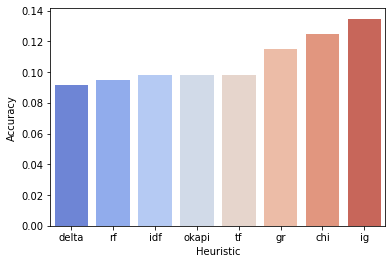

In [15]:
final_dataframe = final_dataframe.sort_values(by = ['Accuracy'])
_ = sns.barplot(final_dataframe.Heuristic, final_dataframe.Accuracy, palette = "coolwarm")